Parameters of the largest circle:
Center: (106, 257)
Radius: 16
Sigma : 2.8


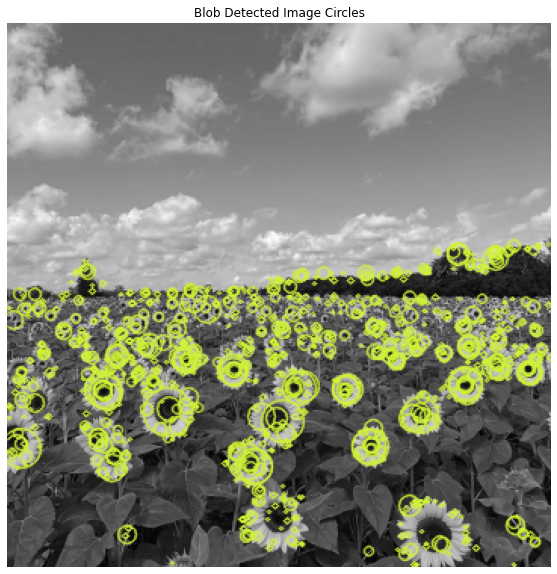

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower field image
image = cv2.imread('./Images/the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set up parameters for scale-space extrema detection
min_sigma = 0.1  # Minimum sigma value (smaller values for smaller blobs)
max_sigma = 2.8  # Maximum sigma value (larger values for larger blobs)
num_sigma = 6 # Number of sigma values to test
threshold = 0.38  # Threshold for blob detection

# Create an empty list to store detected circles
circles = []

# Loop through different sigma values to detect blobs at different scales
for sigma in np.linspace(min_sigma, max_sigma, num_sigma):
    # Apply LoG (Laplacian of Gaussian) to the grayscale image with the current sigma
    Gau = cv2.GaussianBlur(gray_image, (0, 0), sigma)
    Lap = cv2.Laplacian(Gau, cv2.CV_64F)

    # Calculate the absolute value of Laplacian values
    abs_Lap = np.abs(Lap)

    # Create a binary image where blobs are detected using the threshold
    blob_mask = abs_Lap > threshold * abs_Lap.max()

    # Find contours in the blob mask
    contours, _ = cv2.findContours(blob_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius, sigma))

# Sort the detected circles by radius in descending order
circles.sort(key=lambda x: -x[1])

# Report the parameters of the largest circle
largest_circle = circles[0]
center, radius, sigma = largest_circle

print("Parameters of the largest circle:")
print(f"Center: {center}")
print(f"Radius: {radius}")
print(f"Sigma : {sigma}")

# Set the desired line thickness for drawn circles
line_thickness = 1

# Draw all detected circles with the specified line thickness
output_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv2.circle(output_image, center, radius, (56, 242, 208), line_thickness,lineType=cv2.LINE_AA)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Blob Detected Image Circles')
plt.show()


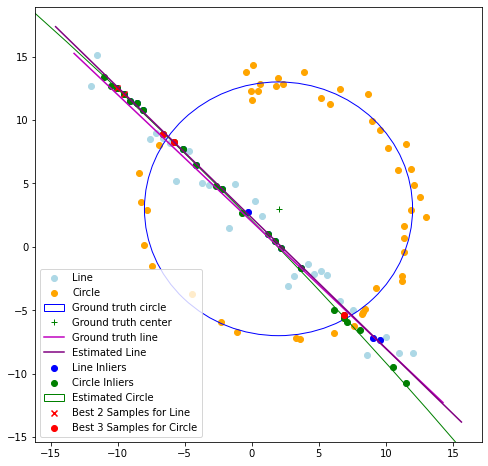

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

# Seed for reproducibility
np.random.seed(219)

N = 100
half_n = N // 2
r = 10
center_x, center_y = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
angles = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = center_x + (r + noise) * np.cos(angles)
y_circle = center_y + (r + noise) * np.sin(angles)

points_circle = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
slope, intercept = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = slope * x_line + intercept + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((points_circle, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], color='lightblue', label='Line')
ax.scatter(points_circle[:, 0], points_circle[:, 1], color='orange', label='Circle')
circle_gt = plt.Circle((center_x, center_y), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(center_x, center_y, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = slope * x_range + intercept
plt.plot(x_range, y_range, color='m', label='Ground truth line')



# Define a function to calculate the line equation from two points
def calculate_line_equation(x1, y1, x2, y2):
    # Calculate differences in x and y coordinates
    delta_x = x2 - x1
    delta_y = y2 - y1
    
    # Calculate magnitude
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    
    # Calculate coefficients of the line equation
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_fit_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        # Randomly sample two points
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        # Calculate line equation coefficients
        a, b, d = calculate_line_equation(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a * X[:, 0] + b * X[:, 1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 50000
threshold = 0.15
min_inliers = 15


# Fit a line using RANSAC
best_line_model, line_inlier_indices = ransac_fit_line(X_line, iterations, threshold, min_inliers)

# Define a function to compute the circle equation from three points
def compute_circle_equation(x1, y1, x2, y2, x3, y3):
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    slope1 = (x2 - x1) / (y2 - y1) if y2 - y1 != 0 else 0
    slope2 = (x3 - x2) / (y3 - y2) if y3 - y2 != 0 else 0
    
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# Use RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_center, y_center, radius = compute_circle_equation(x1, y1, x2, y2, x3, y3)
        
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# Parameters for circle estimation
circle_iterations = 50000
circle_threshold = 0.25 # Adjust the threshold as needed
circle_min_inliers = 15

# Identify the remaining points (not explained by the line)
remaining_indices = [i for i in range(len(X)) if i not in line_inlier_indices]
remaining_points = X[remaining_indices]

# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remaining_points, circle_iterations, circle_threshold, circle_min_inliers)

# Plot the results

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='Estimated Line', color='purple')

ax.scatter(X_line[line_inlier_indices, 0], X_line[line_inlier_indices, 1], color='blue', label='Line Inliers')

# Find the best 2 samples for the line
best_line_sample_indices = line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]

# Plot the inliers of the circle
ax.scatter(remaining_points[circle_inlier_indices, 0], remaining_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='Estimated Circle')
ax.add_artist(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remaining_points[best_circle_sample_indices]

# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')

plt.legend()
plt.show()


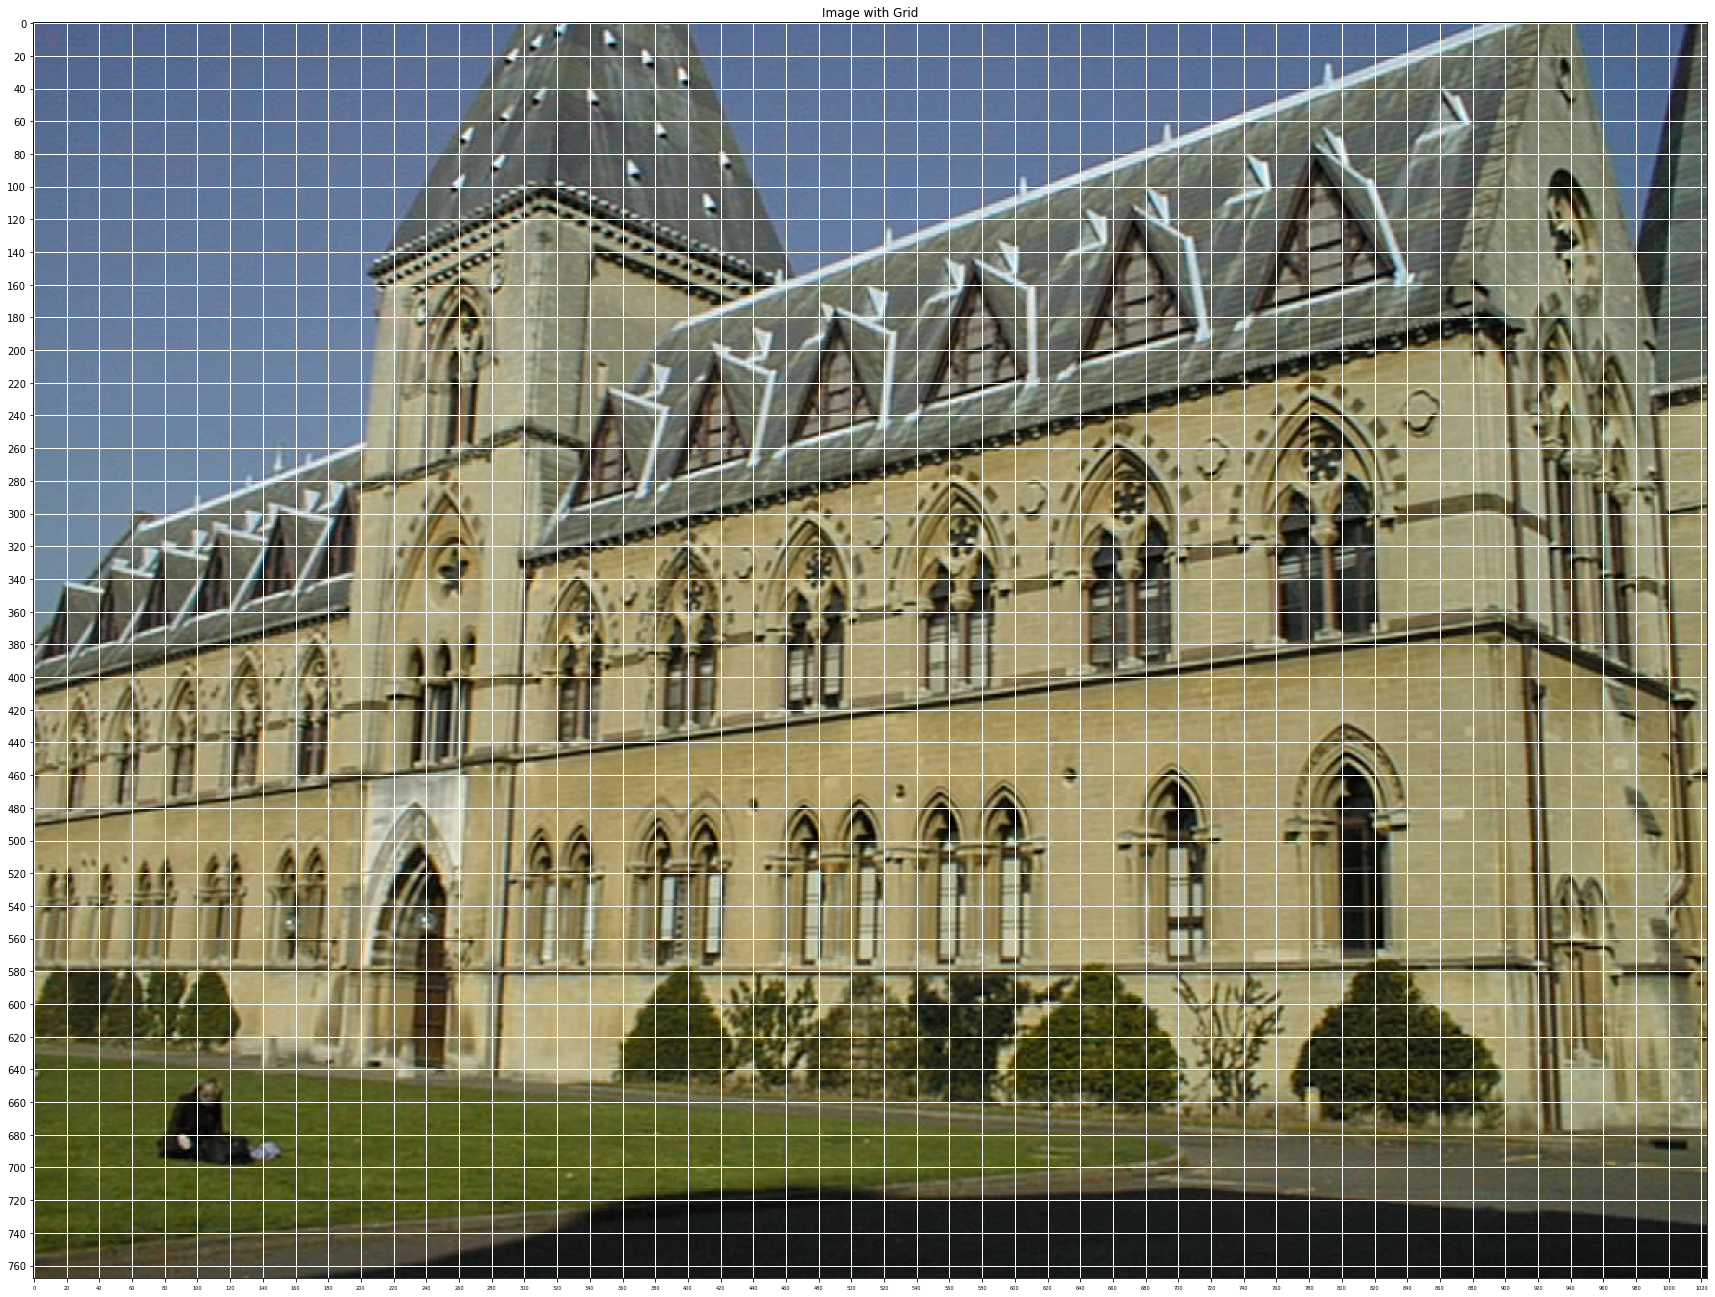

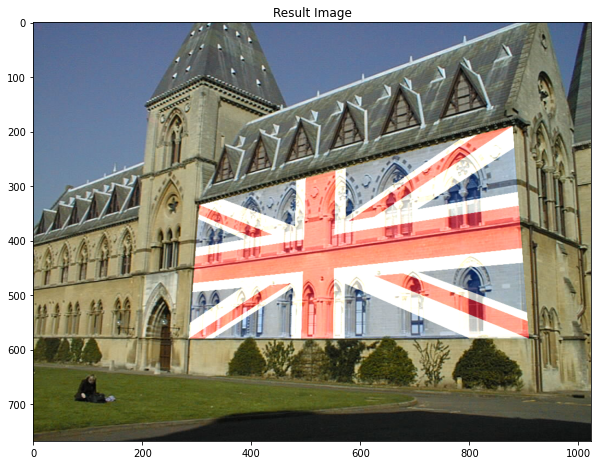

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image_with_grid(image, grid_size=20):
    plt.figure(figsize=(30, 30))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks(np.arange(0, image.shape[1], grid_size), fontsize=5)
    plt.yticks(np.arange(0, image.shape[0], grid_size))
    plt.grid(True, color='white', linewidth=1)
    plt.title('Image with Grid')
    plt.show()

# Load the main image and the overlay image
# main_image = cv2.imread('./Images/001.jpg')
# main_image = cv2.imread('./Images/002.jpg')
# main_image = cv2.imread('./Images/003.jpg')
main_image = cv2.imread('./Images/004.jpg')
overlay_image = cv2.imread('./Images/Flag_of_the_United_Kingdom_(1-2).svg')


# Display the main image with a grid
display_image_with_grid(main_image)

# Define the four points on the main image that form a planar surface
# points_on_main = np.array([[140, 200], [520, 290], [520, 520], [130, 520]], dtype=np.float32)
# points_on_main = np.array([[115, 165], [555, 230], [555, 465], [95, 480]], dtype=np.float32)
# points_on_main = np.array([[540, 380], [835, 355], [840, 600], [540, 580]], dtype=np.float32)
points_on_main = np.array([[305, 335], [880, 190], [910, 580], [285, 580]], dtype=np.float32)


# Define the corresponding points on the overlay image (in the same order)
points_on_overlay = np.array([[0, 0], [overlay_image.shape[1], 0], [overlay_image.shape[1], overlay_image.shape[0]], [0, overlay_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv2.findHomography(points_on_overlay, points_on_main)

# Warp the overlay image onto the main image using the homography
overlay_warped = cv2.warpPerspective(overlay_image, homography_matrix, (main_image.shape[1], main_image.shape[0]))

# Blend the warped overlay image with the main image
result_image = cv2.addWeighted(main_image, 1, overlay_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()


In [1]:
import cv2 as cv
import random
import numpy as np
import matplotlib.pyplot as plt

# Import images
img1 = cv.imread('./Images/img1.ppm')  
img2 = cv.imread('./Images/img2.ppm')  
img3 = cv.imread('./Images/img3.ppm')  
img4 = cv.imread('./Images/img4.ppm')  
img5 = cv.imread('./Images/img5.ppm')

def random_sample(data_list):
    """
    Returns a list of 3 random samples from a given list
    """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def sift_match(im1, im2):

    GOOD_MATCH_PERCENT = 0.65

    # Detect sift features
    sift = cv.SIFT_create()
    keypoint_1, descriptors_1 = sift.detectAndCompute(im1,None)
    keypoint_2, descriptors_2 = sift.detectAndCompute(im2,None)

    # Match features.
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(descriptors_1, descriptors_2, k = 2) 

    # Filter good matches using ratio test in Lowe's paper
    good_matches = []

    for a,b in matches:
        if a.distance < GOOD_MATCH_PERCENT*b.distance:
            good_matches.append(a)

    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoint_1[match.queryIdx].pt
        points2[i, :] = keypoint_2[match.trainIdx].pt

    # Plot the matching
    fig, ax = plt.subplots(figsize = (15,15))
    ax.axis('off')
    matched_img = cv.drawMatches(im1, keypoint_1, im2, keypoint_2, good_matches, im2, flags = 2)
    plt.imshow(cv.cvtColor(matched_img,cv.COLOR_BGR2RGB))
    plt.show()

    result = np.concatenate((points1,points2), axis = 1)

    return result

In [2]:
def calculateHomography(correspondences):
    temp_list = []
    for points in correspondences:
        p1 = np.matrix([points.item(0), points.item(1), 1]) # (x1,y1)
        p2 = np.matrix([points.item(2), points.item(3), 1]) # (x2,y2)

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        temp_list.append(a1)
        temp_list.append(a2)

    assemble_matrix = np.matrix(temp_list)

    #svd composition
    u, s, v = np.linalg.svd(assemble_matrix)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize 
    h = (1/h.item(8)) * h
    return h

In [3]:
def loss(matched_points, h):
    point1 = np.transpose(np.matrix([matched_points[0].item(0), matched_points[0].item(1), 1]))
    point2 = np.transpose(np.matrix([matched_points[0].item(2), matched_points[0].item(3), 1]))
    
    # Estimate the point after applying the homography
    transformed_point2 = np.dot(h, point1)
    transformed_point2 = (1/transformed_point2.item(2))*transformed_point2

    # Calculate the error between the actual and estimated point
    error = point2 - transformed_point2
    
    return np.linalg.norm(error)

def ransac(matched_points):
    maxInliers = 0
    best_H = None
    for i in range(10):
        random_points = random_sample(matched_points)

        # Generate the homography 
        homography = calculateHomography(random_points)
        num_inliers = 0

        # Find the inliers
        for i in range(len(matched_points)):
            d = loss(matched_points[i], homography)
            if d < 3:
                num_inliers += 1

        if num_inliers > maxInliers:
            maxInliers = num_inliers
            best_H = homography
    
    return best_H

In [4]:
def homography_reshape(homography):
    homography_ = np.array(homography)
    homography_ = homography_.reshape(3,3)
    homography_ = homography_/(homography_[-1][-1])
    return homography_

In [5]:
def plot_warped(im1, im2, h):
    width = im1.shape[1] + im2.shape[1]
    height = im1.shape[0] + im2.shape[0]
    result = cv.warpPerspective(im1, h, (width, height))
    result[0:im2.shape[0], 0:im2.shape[1]] = im2
    fig, ax = plt.subplots(1,1,figsize= (8,8))
    ax.imshow(cv.cvtColor(result,cv.COLOR_BGR2RGB))

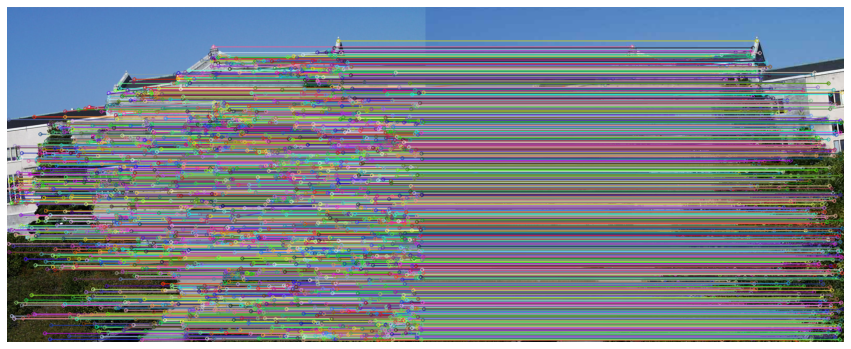

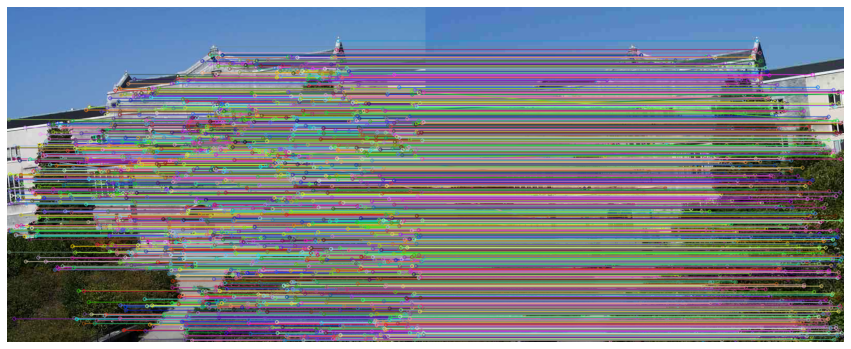

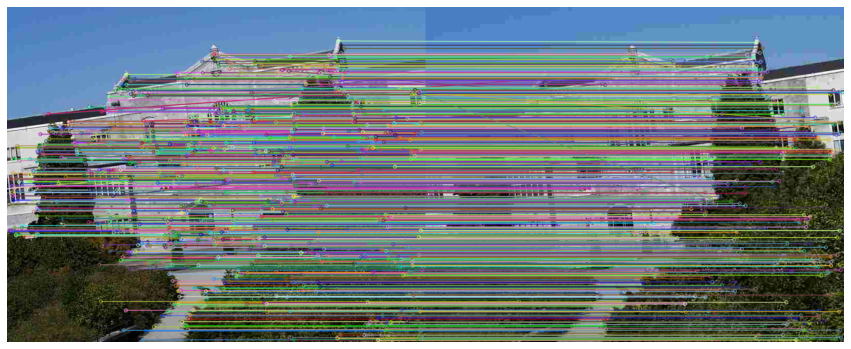

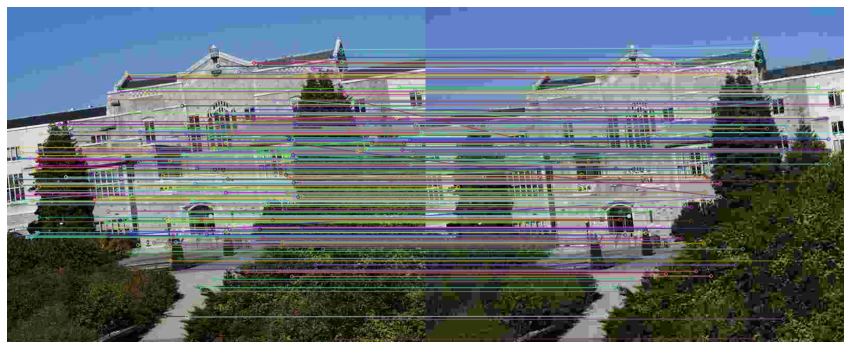

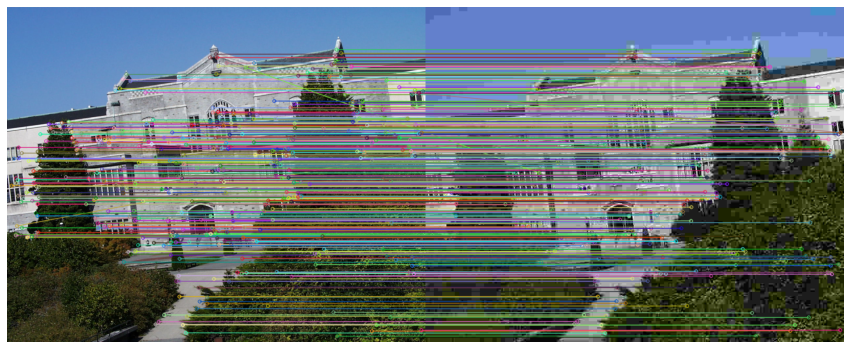

[[ 9.55187838e-01 -4.14973111e-03  1.44451225e+00]
 [-1.00177746e-02  9.85355807e-01  5.14293903e+00]
 [-5.91689809e-05  6.46971773e-05  1.00000000e+00]]


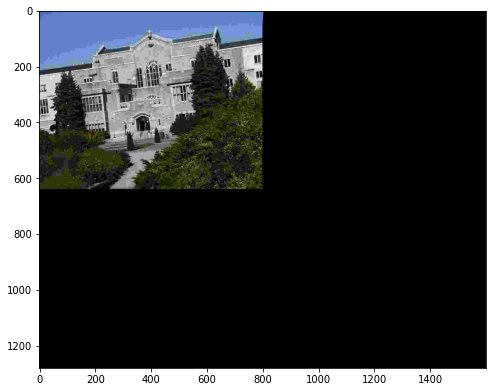

In [6]:
match1_2 = sift_match(img1,img2)
match2_3 = sift_match(img2,img3)
match3_4 = sift_match(img3,img4)
match4_5 = sift_match(img4,img5)
match1_5 = sift_match(img1,img5)

# Generate Correspondence Matrices
correspondenceMatrix1_2 = np.matrix(match1_2)
correspondenceMatrix2_3 = np.matrix(match2_3)
correspondenceMatrix3_4 = np.matrix(match3_4)
correspondenceMatrix4_5 = np.matrix(match4_5)

# Run ransac algorithm
H1_2 = ransac(correspondenceMatrix1_2)
H2_3 = ransac(correspondenceMatrix2_3)
H3_4 = ransac(correspondenceMatrix3_4)
H4_5 = ransac(correspondenceMatrix4_5)

# Reshaping the homography to the matric format
H1_2 = homography_reshape(H1_2)
H2_3 = homography_reshape(H2_3)
H3_4 = homography_reshape(H3_4)
H4_5 = homography_reshape(H4_5)

H1_5 = H4_5@H3_4@H2_3@H1_2
H1_5 = homography_reshape(H1_5)
print(H1_5)

plot_warped(img1,img5,H1_5)